# Deep Q-Learning for Hungry Geese game

This is the final project for "Machine Learning: Advanced" course provided by Otus. Here we leverage reinforcement learning to teach the agent (one of given geese) how to play and win the game.

This game was implemented for following competition. https://www.kaggle.com/competitions/hungry-geese. By this link you can find the rules of the game.

Following code is partly based on following guide: https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/reinforce-learning-DQN.html and it was significantly modified in order to adopt it for given task.

In [1]:
import numpy as np
import pandas as pd
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, GreedyAgent
from kaggle_environments import make

from collections import OrderedDict, namedtuple, deque
from typing import Iterator, Tuple, List
from copy import deepcopy

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import Adam, Optimizer

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from matplotlib import pyplot as plt
%matplotlib inline

Loading environment lux_ai_s3 failed: No module named 'chex'
termcolor not installed, skipping dependency
No pygame installed, ignoring import


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
N_ROWS = 7                        # rows number in the grid
N_COLUMNS = 11                    # cols number in the grid
N_ENEMIES = 3                     # number of geese-enemies
DIMS = (N_ENEMIES + 1) * 4 + 1    # dimentions number of encoded states

LR = 0.001                        # learning rate
REPLAY_SIZE = 1000                # max size of replay memory
NUM_EPOCHS = 5000                 # epochs number
WARM_START_SIZE = 3000            # number of steps to fill up empty replay memory
BATCH_SIZE = 16                   # batch size
PLC_SYNC_RATE = 5                 # number of steps performed before optimizing policy net with respect to one batch
TGT_SYNC_RATE = 10                # number of batches processed between each parget nets' updates  
RANDOM_STATE = 2024               # ranmom_state

MODEL_PATH = '../models/'         # checkpoint folder

In [4]:
# define an instance of replay memory

Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "done", "new_state"],
)

In [5]:
# define an enemy goose we're aimed to outperform

ENEMY_GOOSE = GreedyAgent(Configuration({'rows': N_ROWS, 'columns': N_COLUMNS}))

## Classes and functions definition

In [6]:
# functions to create state representation

def encode_state(obses, my_index=0):

    """Creates 3-D state representation

    Args:
        obses: states info
        my_index: index of my goose

    Returns:
        enc_state

    """

    enc_state = torch.ones((N_ROWS, N_COLUMNS)).long() * DIMS
    geese_info = deepcopy(obses[-1]['geese'])
    food_info = torch.tensor(obses[-1]['food'])

    my_goose = geese_info.pop(my_index)

    # my goose
    enc_state = _process_goose(my_goose, enc_state, head_val=0,
                               body_val=2 * (N_ENEMIES + 1),
                               tail_val=N_ENEMIES + 1)

    # enemies
    for idx, goose in enumerate(geese_info):
        enc_state = _process_goose(goose, enc_state, head_val=idx + 1,
                                   body_val=2 * (N_ENEMIES + 1) + 1 + idx,
                                   tail_val=N_ENEMIES + 2 + idx)

    # food
    enc_state[food_info // N_COLUMNS, food_info % N_COLUMNS] = DIMS - 1

    # centering
    head_pos = (enc_state == 0).nonzero(as_tuple=False)
    enc_state = _center(enc_state, head_pos)

    # one hot encoding
    enc_state = torch.nn.functional.one_hot(enc_state).permute(2, 0, 1)

    # add previous state info
    if len(obses) > 1:
        prev_enc_state = _encode_prev_state(obses, head_pos)
        enc_state = enc_state + prev_enc_state

    # remove redundant dim
    enc_state = enc_state[:-1, :, :]
    enc_state = enc_state.view(-1, DIMS, N_ROWS, N_COLUMNS).type(torch.float32)

    return enc_state


def _encode_prev_state(obses, head_pos, my_index=0):

    prev_enc_state = torch.ones((N_ROWS, N_COLUMNS)).long() * DIMS
    prev_geese_info = deepcopy(obses[-2]['geese'])
    my_goose = prev_geese_info.pop(my_index)

    # my goose
    prev_enc_state = _put_head(my_goose, prev_enc_state,
                               head_val=2 * (N_ENEMIES + 1) + 4)

    # enemies
    for idx, goose in enumerate(prev_geese_info):
        prev_enc_state = _put_head(goose, prev_enc_state,
                                   head_val=2 * (N_ENEMIES + 1) + 5 + idx)

    # centering
    prev_enc_state = _center(prev_enc_state, head_pos)

    # one hot encoding
    prev_enc_state = torch.nn.functional.one_hot(prev_enc_state)\
        .permute(2, 0, 1)

    return prev_enc_state


def _process_goose(goose, enc_state, head_val, body_val, tail_val):

    enc_state = _put_head(goose, enc_state, head_val)
    enc_state = _put_body(goose, enc_state, body_val)
    enc_state = _put_tail(goose, enc_state, tail_val)

    return enc_state


def _put_head(goose, enc_state, head_val):
    if len(goose) > 0:
        cell = goose[0]
        enc_state[cell // N_COLUMNS, cell % N_COLUMNS] = head_val
    return enc_state


def _put_body(goose, enc_state, body_val):
    for cell in goose[1:-1]:
        enc_state[cell // N_COLUMNS, cell % N_COLUMNS] = body_val
    return enc_state


def _put_tail(goose, enc_state, tail_val):
    if len(goose) > 1:
        cell = goose[-1]
        enc_state[cell// N_COLUMNS, cell % N_COLUMNS] = tail_val
    return enc_state


def _center(curr_state, coord):

    y_pos = int(coord[0][0].detach().numpy())
    x_pos = int(coord[0][1].detach().numpy())
    y_des = N_ROWS // 2
    x_des = N_COLUMNS // 2

    if y_des-y_pos <= 0:
        centered_curr_state = torch.cat((curr_state[y_pos - y_des:, :],
                                         curr_state[:y_pos - y_des, :]))
    else:
        centered_curr_state = torch.cat((curr_state[y_des + y_pos + 1:, :],
                                         curr_state[:y_des + y_pos + 1, :]))

    if x_des-x_pos <= 0:
        centered_curr_state = torch.cat((centered_curr_state[:, x_pos -
                                                             x_des:],
                                         centered_curr_state[:, :x_pos -
                                                             x_des]),
                                        dim=1)
    else:
        centered_curr_state = torch.cat((centered_curr_state[:, x_des +
                                                             x_pos + 1:],
                                         centered_curr_state[:, :x_des +
                                                             x_pos + 1]),
                                        dim=1)

    return centered_curr_state

In [7]:
def dql_agent(obs, config):

    """Wrapper for DQN model aimed to 
       run and visualize game.
    """

    global obs_list, agent, policy_net
    obs_list.append(obs)
    agent.enc_state = encode_state(obs_list)

    with torch.no_grad():
        action = agent.get_action(policy_net, 
                                  epsilon=0,
                                  device='cpu')
    action_name = agent.action_space[action]

    return action_name


def play_game(f_agent, render=True):

    """Runs and visualizes game.

    Args:
        f_agent: function representing your agent
        render: if visualization required

    Returns:
        place: place of your agent (if visualization is not required)
        win: True if your agent won (if visualization is not required)
    """

    global model, obs_list, agent, policy_net 
    obs_list = []
    agent = model.agent
    policy_net = model.policy_net

    env = make("hungry_geese")
    geese = [f_agent] + ["greedy"] * N_ENEMIES
    run = env.run(geese)
    scores = [x['reward'] for x in run[-1]]
    place = len(scores) - list(np.argsort(scores)).index(0)
    win = place == 1

    if render:
        env.render(mode='ipython', width=500, height=500)
        print(f"your goose is white (placed {place})")
    else:
        return place, win


def play_n_games(f_agent, num_games=100):

    """Runs several games.

    Args:
        f_agent: function representing your agent
        num_games: number of games to play

    Returns:
        places: places of your agent
        wins: outcomes (wether your agent won the games)
    """

    wins = []
    places = []

    for i in range(num_games):
        place, win = play_game(f_agent, render=False)
        places.append(place)
        wins.append(win)

    return places, wins

In [8]:
# Visualization

def smoothed_plot(values, name):

    """Gives smoothed plot.

    Args:
        values: values to plot
        name: plot's title
    """
    
    plt.figure()
    pd.Series(values).rolling(100).mean().plot()
    plt.title(name)
    plt.show()

def show_performance(f_agent, f_baseline="greedy", num_games=100):

    """Plots histograms of obtained places.

    Args:
        f_agent: function representing your agent
        f_baseline: baseline for comparison
        num_games: number of games to play
    """

    agent_places, agent_wins = play_n_games(f_agent, num_games)
    baseline_places, baseline_wins = play_n_games(f_baseline, num_games)

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    pd.Series(baseline_places).hist(ax=axes[0])
    pd.Series(agent_places).hist(ax=axes[1])

    baseline_win_rate = np.sum(baseline_wins) / num_games
    dqn_win_rate = np.sum(agent_wins) / num_games

    axes[0].set_title(f"Greedy baseline. Win rate = {baseline_win_rate}")
    axes[1].set_title(f"DQN. Win rate = {dqn_win_rate}")

    plt.show()

In [9]:
class DQN(nn.Module):

    """Base Deep Q-Network.

    Args:
        n_rows: number of rows in the environment
        n_cols: number of cols in the environment
        n_ch: number of chanels in state representation

    """

    def __init__(self, n_rows: int = 7, n_cols: int = 11, n_ch: int = 17):

        super(DQN, self).__init__()
        fc1_size = (n_rows - 2 * 3) * (n_cols - 2 * 3) * 256
        self.conv1 = nn.Conv2d(n_ch, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(fc1_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [10]:
class ReplayBuffer:
    """Replay Buffer for storing past experiences
    allowing the agent to learn from them.

    Args:
        capacity: size of the buffer

    """

    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """Add experience to the buffer.

        Args:
            experience: tuple (state, action, reward, done, new_state)
"""
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, \
            dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            torch.cat(states, dim=0),
            torch.tensor(actions),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.bool),
            torch.cat(next_states, dim=0),
        )

In [11]:
class RLDataset(IterableDataset):
    """Iterable Dataset containing the ExperienceBuffer which will be updated
    with new experiences during training.

    Args:
        buffer: replay buffer
        sample_size: number of experiences to sample at a time

    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Iterator[Tuple]:
        states, actions, rewards, \
            dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

In [12]:
class Goose:
    def __init__(self, replay_buffer) -> None:
        """Base Agent (Goose) class handling the interaction
        with the environment.

        Args:
            replay_buffer: replay buffer storing experiences
            config: enviroment configuration

        """
        
        self.init_env()
        self.action_space = ["NORTH", "SOUTH", "WEST", "EAST"]
        self.replay_buffer = replay_buffer
        self.places = []
        self.surv_steps = []
        self.reset()

    def init_env(self):
        """Initializes enviroment objects."""
        geese = [None] + ["greedy"] * N_ENEMIES
        self.env = make("hungry_geese")
        self.trainer = self.env.train(geese)

    def reset(self) -> None:
        """Resents the environment and updates the state."""
        self.state = self.trainer.reset()
        self.obs_list = []
        self.obs_list.append(self.state)
        self.enc_state = encode_state(self.obs_list)

    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """Using the given network, decide what action to carry out
        using an epsilon-greedy policy.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            action

        """
        if np.random.random() < epsilon:
            action_name = ENEMY_GOOSE(Observation(self.state))
            action = self.action_space.index(action_name)

        else:
            state = self.enc_state.to(device)
            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())

        return action

    @torch.no_grad()
    def play_step(
        self,
        net: nn.Module,
        epsilon: float = 0.0,
        device: str = "cpu",
    ) -> Tuple[float, bool]:
        """Carries out a single interaction step between
        the agent and the environment.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            reward, done

        """
        action = self.get_action(net, epsilon, device)
        new_state, reward, \
            done, _ = self.trainer.step(self.action_space[action])
        reward = self._redefine_reward(reward, done)

        if done:
            score = self.env.state[0]['reward']
            place = sum([goose['reward'] > score
                         for goose in self.env.state]) + 1
            self.places.append(place)
            self.surv_steps.append(self.env.state[0]
                                   ['observation']['step'] + 1)

        else:
            self.obs_list.append(new_state)

        enc_new_state = encode_state(self.obs_list)
        exp = Experience(self.enc_state, action, reward, done, enc_new_state)
        self.replay_buffer.append(exp)
        self.state = new_state
        self.enc_state = enc_new_state

        if done:
            self.reset()

        return reward, done

    
    def _redefine_reward(self, reward: float, done: bool):
        """Change some reward values for more efficient learning

        Args:
            reward: initial reward
            done: if the episode is finished

        Returns:
            reward

        """
        # if done and reward == 0:  # collision
        #      reward = -1000
        if reward == 201:       # first step
             reward = 100
        elif reward == 101:     # eating   
            reward = 150
        return reward

In [13]:
class DQNLightning(LightningModule):
    def __init__(
        self,
        batch_size: int = 16,
        lr: float = 1e-2,
        gamma: float = 0.99,
        plc_sync_rate: int = 5,
        tgt_sync_rate: int = 10,
        replay_size: int = 1000,
        warm_start_size: int = 1000,
        eps_last_frame: int = 1000,
        eps_start: float = 1.0,
        eps_end: float = 0.01,
        episode_length: int = 200,
        device: str = "cuda"
    ) -> None:
        """Basic DQN Model.

        Args:
            batch_size: size of the batches")
            lr: learning rate
            env: gym environment tag
            gamma: discount factor
            tgt_sync_rate: how many frames do we update the target network
            replay_size: capacity of the replay buffer
            warm_start_size: how many samples do we use to fill our buffer
                             at the start of training
            eps_last_frame: what frame should epsilon stop decaying
            eps_start: starting value of epsilon
            eps_end: final value of epsilon
            episode_length: max length of an episode
            warm_start_steps: max episode reward in the environment
            device: cpu or cuda

        """
        super().__init__()
        self.save_hyperparameters()

        self.policy_net = DQN(n_rows=N_ROWS, n_cols=N_COLUMNS,n_ch=DIMS)
        self.target_net = DQN(n_rows=N_ROWS, n_cols=N_COLUMNS,n_ch=DIMS)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Goose(self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_size)

    def populate(self, steps: int = 1000) -> None:
        """Carries out several random steps through the environment
        to initially fill up the replay buffer with experiences.

        Args:
            steps: number of random steps to populate the buffer with

        """
        for _ in range(steps):
            self.agent.play_step(self.policy_net, epsilon=1.0)

    def accumulate(self, steps: int = 5, epsilon: int = 0) -> None:

        for _ in range(steps):

            # step through environment with agent
            reward, done = self.agent.play_step(self.policy_net, epsilon, 
                                                self.hparams.device)
            self.episode_reward += reward

            if done:
                self.total_reward = self.episode_reward
                self.episode_reward = 0
                self.log("places", self.agent.places[-1])
                self.log("surv_steps", self.agent.surv_steps[-1], 
                         prog_bar=True)
                self.log("total_reward", self.total_reward, prog_bar=True)

        return reward, done 

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Passes in a state x through the network and gets
        the q_values of each action as an output.

        Args:
            x: environment state

        Returns:
            q values

        """
        output = self.policy_net(x)
        return output

    def dqn_mse_loss(self, batch: Tuple[torch.tensor, torch.tensor]) -> torch.tensor:
        """Calculates the mse loss using a mini batch from the replay buffer.

        Args:
            batch: current mini batch of replay data

        Returns:
            loss

        """
        states, actions, rewards, dones, next_states = batch
        state_action_values = self.policy_net(states)\
            .gather(1, actions.long().unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values *\
            self.hparams.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def get_epsilon(self, start: int, end: int, frames: int) -> float:
        if self.global_step > frames:
            return end
        return start - (self.global_step / frames) * (start - end)

    def training_step(self, batch: Tuple[torch.tensor, torch.tensor], nb_batch) -> OrderedDict:
        """Carries out a single step through the environment to update
        the replay buffer. Then calculates loss based on
        the minibatch received.

        Args:
            batch: current mini batch of replay data
            nb_batch: batch number

        Returns:
            Training loss and log metrics

        """
        epsilon = self.get_epsilon(self.hparams.eps_start,
                                   self.hparams.eps_end,
                                   self.hparams.eps_last_frame)
        self.log("epsilon", epsilon)

        reward, done = self.accumulate(self.hparams.plc_sync_rate, epsilon)

        # calculates training loss
        loss = self.dqn_mse_loss(batch)

        # Soft update of target network
        if self.global_step % self.hparams.tgt_sync_rate == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        self.log("train_loss", loss)
        self.log("steps", self.global_step, logger=False, prog_bar=True)

        return loss

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer."""
        optimizer = Adam(self.policy_net.parameters(), lr=self.hparams.lr)
        return optimizer

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset 
        used for retrieving experiences."""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader."""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch."""
        return batch[0].device.index if self.on_gpu else "cpu"

## Training

In [14]:
pl.seed_everything(RANDOM_STATE)

logger = TensorBoardLogger("tb_logs", name="conv_nn")
model = DQNLightning(batch_size=BATCH_SIZE, 
                     lr=LR, 
                     replay_size=REPLAY_SIZE, 
                     warm_start_size=WARM_START_SIZE, 
                     tgt_sync_rate=TGT_SYNC_RATE, 
                     plc_sync_rate=PLC_SYNC_RATE)

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=NUM_EPOCHS,
    logger=logger,
)

trainer.fit(model)
trainer.save_checkpoint(os.path.join(MODEL_PATH, "model.ckpt"))

Seed set to 2024
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | policy_net | DQN  | 723 K  | train
1 | target_net | DQN  | 723 K  | train
--------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.788     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
/home/max/.cache/pypoetry/virtualenvs/hungry-geese-cLhaeidc-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


In [ ]:
# model = DQNLightning.load_from_checkpoint(os.path.join(MODEL_PATH, "model.ckpt"))

## Evaluation

In [23]:
# Visualize a game

play_game(dql_agent)

your goose is white (placed 1)


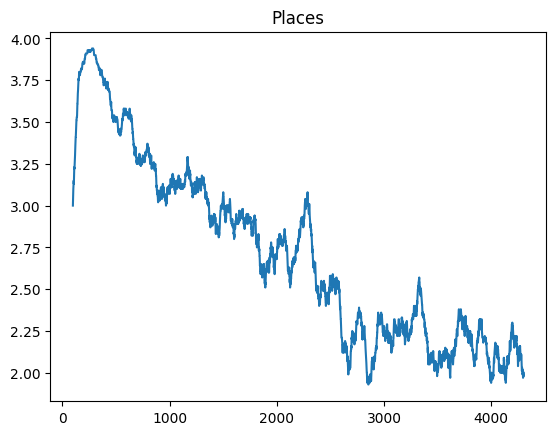

In [ ]:
# places curve

smoothed_plot(model.agent.places, 'Places')

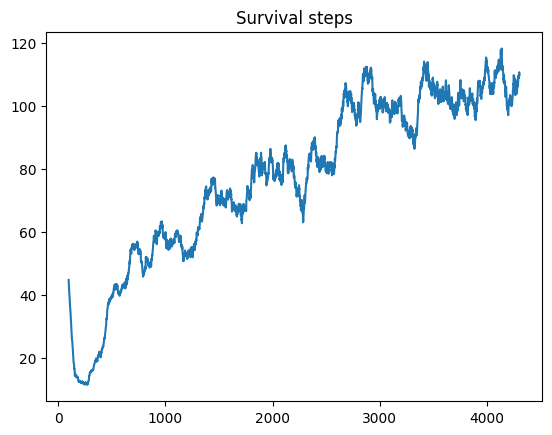

In [ ]:
# steps curve

smoothed_plot(model.agent.surv_steps, 'Survival steps')

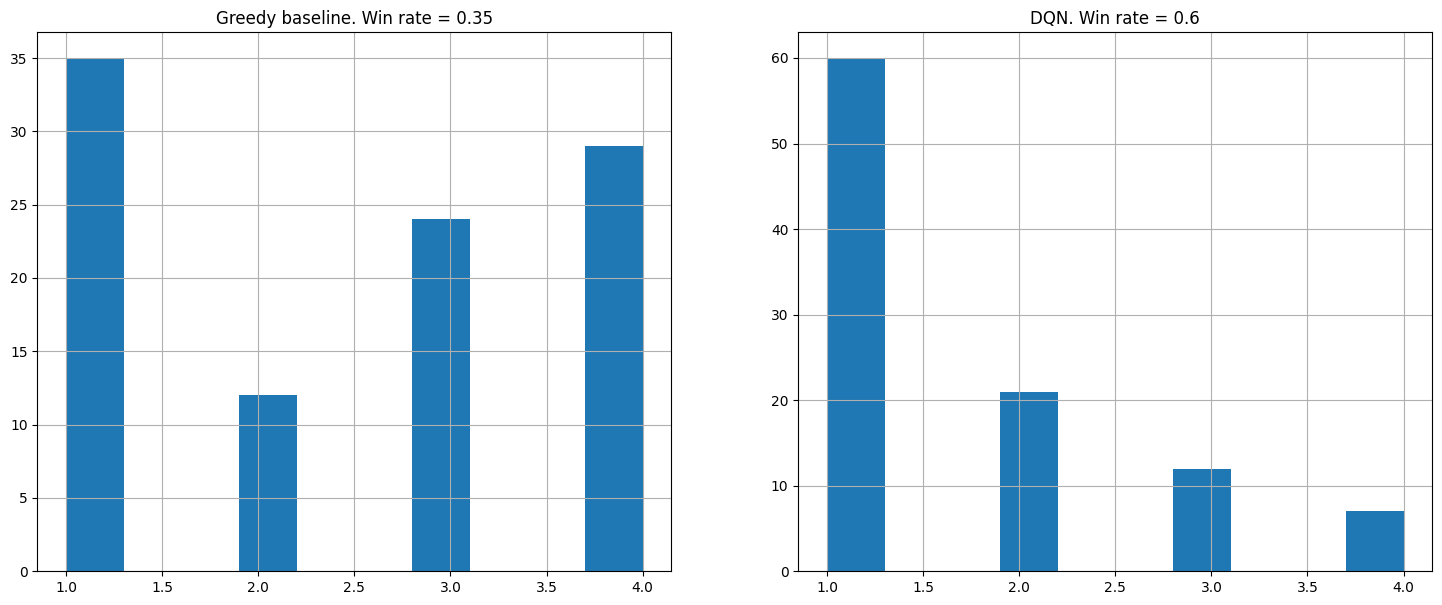

In [21]:
# plot performance histograms

show_performance(dql_agent)

Here we can see that DQN agent significantly outperforms greedy baseline.